<center><span style="font-size:36px;">  🏈Expected Tackle Success Rate (ETSR) and Tackle Index🏈</span> </center>

***

### <font color='289C4E'  align>Table of contents<font><a class='anchor' id='top'></a>
- [Introduction](#1)
- [Data Summary](#2)
- [The ETSR Model](#3)
- [Applying ETSR to Player Data](#4)
- [Testing the ETSR and Tackle Index](#5)
- [How is this useful and innovative?](#6)


***

# Introduction <a class="anchor"  id="1"></a>

This submission is for the Coaching Track for the 2024 NFL Big Data Bowl.

## Tackling Statistics
 Currently, the main metrics that are used to evaluate players and their ability to tackle are composed of raw counts and percentages. We can look at how many solo tackles, assists, and sacks that a player has and we can look at the percentage of tackle attempts they made that were successful. However, we believe that there is a bigger question that needs to be answered...*what makes a good tackle?*

#### By "good", we mean, what differentiates a successful tackle attempt from a missed tackle. 

### Project Goal:
To analyze historical tracking data and extract meaningful features to predict when a tackle attempt will be successful. We will then apply the model to players and determine their "Expected Tackle Success Rate (ETSR)", which we define as "the overall probability that a player's tackle attempt will be successful"

We also introduce the "Tackle Index", which allows us to rank players based on their current track record related to tackling in addition to their ETSR. This accounts for consistent performance and number of games played.

***

# Data Summary <a class="anchor"  id="2"></a>
The data used for this analysis includes 2022 player tracking data, game data, play data, tackle data, and player statistics. To start, we combined this data to create a comprehensive table that could be used to look at every tackle attempt in the tracking data, tied to the ball carrier at the time and the tackler.


We engineered additional features to supplement the data. Examples include:
- Standardized directional and positional data (to account for plays going in different directions)
- Force (Mass*Acceleration)
- Momentum (Mass * speed)
- Relative velocity: We looked at the speed of the ball carrier compared to the tackler
- Relative position: Distance between the ball carrier and tackler throughout the play
- Coefficient of Restitution COR= $\frac{(v_{2f} - v_{1f})}{(v_{2i} - v_{1i})}$ 


In order to look at what distinguishes a successful tackle from a missed tackle, we specifically excluded assists for the current model. Therefore, we looked at **7895** successful tackles and **2001** missed tackles. 

###  $\frac {7895}{9896}$ = 80%

#  The ETSR Model <a class="anchor"  id="3"></a>

Our model of Expected Tackle Success Rate (ETSR) blends the predictions from three classification models: **LGBMClassifier** , **XGBoost Classifier**, and **RandomForestClassifier**.
The two models take the following features into account when assessing whether a tackle attempt will be successful:

- The orientation of the tackler
- The direction of the tackler
- The tackler's acceleration
- The ball carrier's speed
- The distance traveled by the ball carrier
- The speed of the tackler before the attempt
- The speed of the ball carrier before the attempt

By blending combinations of these features (i.e. the average speed of the ball carrier and the maximum speed of the tackler before the tackle attempt), the ETSR model predicts the tackle attempts success with 
### 85.6% Accuracy
The other metrics we used to assess the model's performance include F1 score, precision, recall, and Cohen's Kappa. (See appendix with resources on classification model metrics).


#  Applying ETSR to Player Data <a class="anchor"  id="4"></a>

We propose that coaches utilize the ETSR model for their players that need to be tracked for tackling ability. The ETSR score ranges from 0 to 1, with 1 being the highest expected success rate. However, this metric can be biased towards players with little data because if they only had one tackle attempt and it was successful, their score will be very close to 1. Therefore, we developed a **Tackle Index**  which factors in how many attempts a player actually made (proxy for their snap count).

## Tackle Index Calculation
The tackle index is relative to other players. It can be negative, zero , or positive depending on the previous tackles and missed tackles that the player has made. On the other hand, RTA always ranges from 0 to 1.

#### ${ETSR \times (Tackle Count + (.5 \times Assist Count)} -{[{(1-ETSR) \times Missed Tackle Count}+1]} $


In [3]:

from IPython.display import Image
import warnings
#!pip install eli5
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

#Image("/kaggle/input/shap-plots/LGBMshap.png")


In [4]:

df_games=pd.read_csv('games.csv')
df_players=pd.read_csv('players.csv')
df_plays=pd.read_csv('plays.csv')
df_tackles=pd.read_csv('tackles.csv')
files=[]
for i in range(1,10):
    file='tracking_week_'+str(i)+'.csv'
    files.append(pd.read_csv(file))
    df_tracking=pd.concat(files) 



In [5]:
#change all plays to same direction
def reverse_deg(deg):
    if deg < 180:
        return deg + 180
    if deg >= 180:
        return deg - 180


In [6]:
df_tracking["o_standard"]=np.where(df_tracking["playDirection"] == "left", df_tracking["o"].apply(reverse_deg), df_tracking["o"])
        
df_tracking["dir_standard"] = np.where(df_tracking["playDirection"] == "left", df_tracking["dir"].apply(reverse_deg), df_tracking["dir"])
        
df_tracking["x_standard"] = np.where(df_tracking["playDirection"] == "left", df_tracking["x"].apply(lambda x: 120 - x), df_tracking["x"])
        
df_tracking["y_standard"] =np.where(df_tracking["playDirection"] == "left",  df_tracking["y"].apply(lambda y: 160/3 - y), df_tracking["y"])
    

In [7]:
def create_gameplayid(df):
    df['gameplayid']=df['gameId'].astype(str)+df['playId'].astype(str)
    return df

def create_index(df):
    df['index']=df['nflId'].astype(str)+df['gameplayid']
    return df
df_tracking=create_index(create_gameplayid(df_tracking))

df_plays=create_gameplayid(df_plays)
df_tackles=create_index(create_gameplayid(df_tackles))



In [8]:
def merge_clean_data(df_tracking, df_plays, df_tackles):
    df_tracking_plays_final=pd.merge(pd.merge(df_tracking, df_plays, left_on=['gameplayid', 'gameId', 'playId'], right_on=['gameplayid', 'gameId', 'playId'], how='inner'), df_tackles, left_on=['gameplayid', 'gameId', 'playId', 'nflId'], right_on=['gameplayid', 'gameId', 'playId', 'nflId'], how='inner' )

  
    df_tackles_final=pd.merge(df_tracking_plays_final, df_tackles, left_on=['gameplayid','gameId', 'playId', 'nflId', 'tackle', 'assist', 'pff_missedTackle'], right_on=['gameplayid','gameId', 'playId', 'nflId', 'tackle','assist', 'pff_missedTackle'], how='left', suffixes=['_1', '_2'])
    df_tackles_final=df_tackles_final[((df_tackles_final['gameplayid'].isna()==False))]
    df_tackles_final['tackle_event']=np.where((df_tackles_final['tackle']==1) & (df_tackles_final['event']=='tackle'), 1,0)
    df_tackles_final['missed_tackle']=np.where((df_tackles_final['tackle']==0) & (df_tackles_final['pff_missedTackle']==1), 1, 0)
    df_tackles_final['index']=df_tackles_final['nflId'].astype(str)+df_tackles_final['gameplayid'].astype(str)+df_tackles_final['frameId'].astype(str)
    return df_tackles_final
df_tackles_final=merge_clean_data(df_tracking, df_plays, df_tackles)

In [9]:
def ballcarrier_df(df_players):
    df_ballcarrier_players=df_players.copy()
    df_ballcarrier_players.columns=['nflId_ballcarrier', 'ballCarrierHeight', 'ballCarrierWeight', 'ballcarrierDOB', 'ballcarrierCollege', 'ballcarrierPosition', 'ballCarrierDisplayName']
    
    df_tracking_ballcarrier=df_tracking[['gameplayid', 'frameId','nflId', 'x', 'y', 's', 'a', 'dis',
       'o', 'dir', 'event', 'o_standard', 'dir_standard', 'x_standard',
       'y_standard']]
    df_ballcarrier=pd.merge(df_tracking_ballcarrier, df_ballcarrier_players, left_on='nflId', right_on='nflId_ballcarrier')
    df_ballcarrier=df_ballcarrier[['gameplayid', 'frameId',  'x', 'y', 's', 'a', 'dis', 'o',
       'dir', 'event', 'o_standard', 'dir_standard', 'x_standard',
       'y_standard', 'nflId_ballcarrier', 'ballCarrierHeight',
       'ballCarrierWeight', 'ballcarrierDOB', 'ballcarrierCollege',
       'ballcarrierPosition', 'ballCarrierDisplayName']]
    df_ballcarrier.columns=['gameplayid', 'frameId',  'x_ballcarrier', 'y_ballcarrier', 's_ballcarrier',
                        'a_ballcarrier', 'dis_ballcarrier', 'o_ballcarrier',
       'dir_ball_carrier', 'event_ballcarrier', 'o_standard_ballcarrier', 'dir_standard_ballcarrier', 'x_standard_ballcarrier',
       'y_standard_ballcarrier','nflId_ballcarrier', 'ballCarrierHeight',
       'ballCarrierWeight', 'ballcarrierDOB', 'ballcarrierCollege',
       'ballcarrierPosition', 'ballCarrierDisplayName']
    return df_ballcarrier
    
df_ballcarrier=ballcarrier_df(df_players)


In [10]:
def full_merge(df_tackles_final):
    df_players_tackler=df_players.copy()
    df_players_tackler.columns=['nflId_tackler', 'tacklerHeight', 'tacklerWeight', 'tacklerDOB', 'tacklerCollege', 'tacklerPosition', 'tacklerDisplayName']
    df_tackles_final=pd.merge(df_tackles_final, df_players_tackler, left_on='nflId', right_on='nflId_tackler')
    df_full=pd.merge(df_tackles_final, df_ballcarrier, left_on=['gameplayid','ballCarrierDisplayName','frameId'], right_on=['gameplayid', 'ballCarrierDisplayName','frameId'])
    df_full.rename(columns={ 'x':'x_tackler','y': 'y_tackler', 's':'s_tackler', 'a':'a_tackler', 'dis':'dis_tackler',
       'o':'o_tackler', 'dir':'dir_tackler', 'event':'event_tackler', 'o_standard':'o_standard_tackler',
       'dir_standard':'dir_standard_tackler', 'x_standard':'x_standard_tackler', 'y_standard':'y_standard_tackler'}, inplace=True)
    return df_full
df_full=full_merge(df_tackles_final)

In [11]:
def create_force_features(df_full):
    df_full['force_ballcarrier']=df_full['ballCarrierWeight']*df_full['a_ballcarrier']
    df_full['force_tackler']=df_full['tacklerWeight']*df_full['a_tackler']
    df_full['momentum_ballcarrier']=df_full['ballCarrierWeight']*df_full['s_ballcarrier']
    df_full['momentum_tackler']=df_full['tacklerWeight']*df_full['s_tackler']
    #calculate distance between player tackling and player being tackled
    df_full['dis_ballcarrier_tackler']=np.sqrt(((df_full['x_standard_ballcarrier'] -df_full['x_standard_tackler'])**2)+((df_full['y_standard_ballcarrier'] -df_full['y_standard_tackler'])**2))
    return df_full
df_full=create_force_features(df_full)


In [12]:
import time

def minutes_to_seconds(minutes):
  return minutes * 60

def seconds_to_minutes(seconds):
  return seconds // 60
def convert_minutes_to_seconds(hours_minutes_and_seconds):
  hours, minutes, seconds = hours_minutes_and_seconds.split(':')
  return minutes_to_seconds(int(minutes)) + seconds_to_minutes(float(seconds))




In [13]:
import datetime 
from datetime import datetime

df_full['time']=df_full['time'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f' ))
df_full['time_adj']=df_full['time'].apply(lambda x: x.time())
df_full['time_seconds']=df_full['time_adj'].apply(lambda x: convert_minutes_to_seconds(str(x)))


In [14]:

df_full['time_elapsed']=df_full.groupby(['gameplayid', 'frameId'])['time_seconds'].diff()


In [15]:
df_full.sort_values(by=['gameplayid', 'frameId'], inplace=True)


In [16]:

df_full['relative_direction']=df_full['dir_standard_tackler']-df_full['dir_standard_ballcarrier']
df_full['relative_o']=df_full['o_standard_tackler']-df_full['o_standard_ballcarrier']
df_full['playNullifiedByPenalty'].replace({'Y':1, 'N':0}, inplace=True)

In [17]:
df_groupplay=df_full.groupby(by=['gameplayid', 'displayName'])['dis_ballcarrier_tackler'].min().reset_index()
df_groupplay['tackleframe']=1
df_full=pd.merge(df_groupplay, df_full, left_on=['gameplayid', 'displayName', 'dis_ballcarrier_tackler'], right_on=['gameplayid','displayName', 'dis_ballcarrier_tackler'], how='right')
df_full['tackle_frame_final']=np.where((df_full['tackleframe']==1), 1, 0)
df_full['prior_speed_tackler']=df_full.groupby(['gameplayid', 'displayName'])['s_tackler'].shift(1)
df_full['next_speed_tackler']=df_full.groupby(['gameplayid', 'displayName'])['s_tackler'].shift(-1)
df_full['prior_speed_ballcarrier']=df_full.groupby(['gameplayid', 'displayName'])['s_ballcarrier'].shift(1)
df_full['next_speed_ballcarrier']=df_full.groupby(['gameplayid', 'displayName'])['s_ballcarrier'].shift(-1)


In [18]:
def group_by_play(df_full):
    df_full_grouped=df_full.groupby(by=['gameplayid',  'displayName', 'nflId_tackler', 'nflId_ballcarrier']).agg({'tackle_event':'max', 'assist':'max', 'missed_tackle':'max','playNullifiedByPenalty':'max', 'relative_o':'mean', 'relative_direction':'mean', 'time':['min', 'max'], 'time_seconds':['min', 'max'],'offenseFormation':pd.Series.mode,'tacklerPosition': pd.Series.mode, 'ballcarrierPosition':pd.Series.mode,'offenseFormation':'first',  'x_tackler':['min', 'max','mean'], 'y_tackler':['min', 'max','mean'],
                                  's_tackler':['first', 'last','min', 'max','mean'],'prior_speed_tackler':'max', 'next_speed_tackler':'max', 'prior_speed_ballcarrier':'max', 'next_speed_ballcarrier':'max', 'a_tackler':['min', 'max','mean'], 'dis_tackler':['min', 'max','mean'],
                                   'o_standard_tackler':['min', 'max','mean'],
                                  'dir_standard_tackler':['min', 'max','mean'], 'x_standard_tackler':['min', 'max','mean'], 'y_standard_tackler':['min', 'max','mean'],
                                  'quarter':['min', 'max','mean'], 'down':['min', 'max','mean'], 'yardsToGo':['min', 'max','mean'],
                                  'gameClock':['min', 'max'], 'preSnapHomeScore':['min', 'max','mean'], 'preSnapVisitorScore':['min', 'max','mean'],
                                   'absoluteYardlineNumber':['min', 'max','mean'], 'defendersInTheBox': ['min', 'max','mean'],
                                  'expectedPoints':['min', 'max','mean'],  'tacklerWeight': 'mean',
                                   's_ballcarrier':['first', 'last','min', 'max','mean'],
                                  'a_ballcarrier':['min', 'max','mean'], 'dis_ballcarrier': ['min', 'max','mean'],
                                  'o_standard_ballcarrier':['min', 'max','mean'],'dir_standard_ballcarrier':['min', 'max','mean'],
                                  'x_standard_ballcarrier':['min', 'max','mean'], 'y_standard_ballcarrier':['min', 'max','mean'], 'ballCarrierWeight':'mean', 'force_ballcarrier':['min', 'max','mean'],
                                  'force_tackler':['min', 'max','mean']}).reset_index()
    df_full_grouped.columns =df_full_grouped.columns.map('|'.join).str.strip('|')
    return df_full_grouped
df_full_grouped=group_by_play(df_full)



In [19]:
df_full_grouped=df_full_grouped[df_full_grouped['playNullifiedByPenalty|max']==0]

In [20]:
print('Total plays: ', df_full_grouped['gameplayid'].nunique())
print('Total plays not nullified by penalty: ', df_full_grouped[df_full_grouped['playNullifiedByPenalty|max']==0]['gameplayid'].nunique())
print('Total row count: ', len(df_full_grouped[df_full_grouped['playNullifiedByPenalty|max']==0]))
print('Total missed tackles: ', len(df_full_grouped[((df_full_grouped['missed_tackle|max']==1))]['gameplayid']))
print('Total assists: ', len(df_full_grouped[((df_full_grouped['assist|max']==1))]['gameplayid']))
print('Total tackles: ', len(df_full_grouped[((df_full_grouped['tackle_event|max']==1))]['gameplayid']))

Total plays:  11700
Total plays not nullified by penalty:  11700
Total row count:  16988
Total missed tackles:  2001
Total assists:  5396
Total tackles:  7895


In [21]:
df_speed_subset=df_full[df_full['tackle_frame_final']==1][['gameplayid', 'displayName', 's_tackler', 'prior_speed_tackler', 'next_speed_tackler', 's_ballcarrier', 'prior_speed_ballcarrier', 'next_speed_ballcarrier']]

In [22]:
df_speed_subset.fillna(0, inplace=True)

In [23]:
def create_position_variables(df_full_grouped):

    ballcarrier_position=pd.get_dummies(df_full_grouped[['gameplayid',  'displayName', 'ballcarrierPosition|mode']], columns=['ballcarrierPosition|mode'],drop_first=True).reset_index(drop=True)
    ballcarrier_position.columns=['gameplayid', 'displayName', 'QB_ballcarrier', 'RB_ballcarrier', 'TE_ballcarrier', 'WR_ballcarrier']
    tackler_position=pd.get_dummies(df_full_grouped[['gameplayid','displayName', 'tacklerPosition|mode']], columns=['tacklerPosition|mode'],drop_first=True).reset_index(drop=True)
    tackler_position.columns=['gameplayid', 'displayName', 'tacklerPosition|mode_DB', 'tacklerPosition|mode_DE',
       'tacklerPosition|mode_DT', 'tacklerPosition|mode_FS',
       'tacklerPosition|mode_ILB', 'tacklerPosition|mode_MLB',
       'tacklerPosition|mode_NT', 'tacklerPosition|mode_OLB',
       'tacklerPosition|mode_SS']
    offense_formation=pd.get_dummies(df_full_grouped[['gameplayid', 'displayName','offenseFormation|first']], columns=['offenseFormation|first'], drop_first=True).reset_index(drop=True)
    df_merge=pd.merge(df_full_grouped,ballcarrier_position, on=['gameplayid', 'displayName'] )
    df_merge=pd.merge(df_merge,tackler_position, on=['gameplayid', 'displayName'])
    df_merge=pd.merge(df_merge, offense_formation, on=['gameplayid', 'displayName'])
    
    
    return df_merge
df_full_grouped=create_position_variables(df_full_grouped)

In [24]:
def create_diff_range(df_final):
    df_final['difference_speed']=df_final['s_tackler|max']-df_final['s_ballcarrier|max']
    df_final['difference_a']=df_final['a_tackler|max']-df_final['a_ballcarrier|max']
    df_final['difference_orientation']=df_final['o_standard_tackler|max']-df_final['o_standard_ballcarrier|max']
    df_final['tackler_x_range']=df_final['x_standard_tackler|max']-df_final['x_standard_tackler|min']
    df_final['tackler_y_range']=df_final['y_standard_tackler|max']-df_final['y_standard_tackler|min']
    df_final['tackler_s_range']=df_final['s_tackler|max']-df_final['s_tackler|min']
    df_final['tackler_a_range']=df_final['a_tackler|max']-df_final['a_tackler|min']
    df_final['o_range_tackler']=df_final['o_standard_tackler|max']-df_final['o_standard_tackler|min']
    df_final['dir_range_tackler']=df_final['dir_standard_tackler|max']-df_final['dir_standard_tackler|min']
    df_final['ballcarrier_x_range']=df_final['x_standard_ballcarrier|max']-df_final['x_standard_ballcarrier|min']
    df_final['ballcarrier_y_range']=df_final['y_standard_ballcarrier|max']-df_final['y_standard_ballcarrier|min']
    df_final['ballcarrier_s_range']=df_final['s_ballcarrier|max']-df_final['s_ballcarrier|min']
    df_final['ballcarrier_a_range']=df_final['a_ballcarrier|max']-df_final['a_ballcarrier|min']
    df_final['o_range_ballcarrier']=df_final['o_standard_ballcarrier|max']-df_final['o_standard_ballcarrier|min']
    df_final['dir_range_ballcarrier']=df_final['dir_standard_ballcarrier|max']-df_final['dir_standard_ballcarrier|min']
    df_final['next_speed_diff']= (df_final['next_speed_tackler|max']-df_final['next_speed_ballcarrier|max'])
    df_final['prior_speed_diff']=(df_final['prior_speed_tackler|max']-df_final['prior_speed_ballcarrier|max'])
    df_final['COR']=np.where(df_final['tackle_event|max']==1, (df_final['next_speed_diff']).astype(float)/(df_final['prior_speed_diff']+1).astype(float),0 )
    df_final['COR'].replace([float('inf'), float('-inf')], 0, inplace=True)

    return df_final
df_final=create_diff_range(df_full_grouped)

In [25]:


df_successful_tackles=df_final[df_final['tackle_event|max']==1]
df_successful_tackles['COR'].describe()


count    7.895000e+03
mean     1.020076e+00
std      4.007294e+13
min     -2.251800e+15
25%      1.452991e-01
50%      6.183206e-01
75%      1.781250e+00
max      2.251800e+15
Name: COR, dtype: float64

In [26]:
df_final_subset= df_final.select_dtypes(include='number')
from scipy.stats import pointbiserialr
positive_variables=[]
negative_variables=[]
for col in df_final_subset.columns:
    if df_final_subset[col].isna().sum()==0:
        corr, p =pointbiserialr(df_final_subset[col], df_final_subset['tackle_event|max'])
        if corr >=.08 and corr<.9 and p<.05:
            positive_variables.append(col)
        if corr <=-.08  and corr>=-.9 and p<.05:
            negative_variables.append(col)
        


In [27]:
df_final_subset= df_final.select_dtypes(include='number')
from scipy.stats import pointbiserialr
positive_variables2=[]
negative_variables2=[]
for col in df_final_subset.columns:
    if df_final_subset[col].isna().sum()==0:
        corr, p =pointbiserialr(df_final_subset[col], df_final_subset['missed_tackle|max'])
        if corr >=.08 and corr<.9 and p<.05:
            positive_variables2.append(col)
        if corr <=-.08  and corr>=-.9 and p<.05:
            negative_variables2.append(col)
        


In [28]:
set(positive_variables+negative_variables)
  

{'a_ballcarrier|mean',
 'a_ballcarrier|min',
 'a_tackler|mean',
 'a_tackler|min',
 'assist|max',
 'ballcarrier_x_range',
 'ballcarrier_y_range',
 'difference_speed',
 'dir_range_tackler',
 'dir_standard_tackler|min',
 'dis_ballcarrier|max',
 'dis_ballcarrier|mean',
 'force_ballcarrier|mean',
 'force_ballcarrier|min',
 'force_tackler|mean',
 'force_tackler|min',
 'missed_tackle|max',
 'next_speed_ballcarrier|max',
 'next_speed_diff',
 'o_standard_ballcarrier|mean',
 'o_standard_ballcarrier|min',
 'prior_speed_ballcarrier|max',
 'prior_speed_diff',
 'relative_o|mean',
 's_ballcarrier|last',
 's_ballcarrier|max',
 's_ballcarrier|mean',
 's_ballcarrier|min',
 's_tackler|last',
 'tackler_y_range'}

In [29]:
final_cols=[
'a_ballcarrier|mean',
 'ballcarrier_x_range',
 'a_tackler|mean',
 'ballcarrier_y_range',
 'difference_speed',
 'dir_range_tackler',
 'dir_standard_tackler|min',
 'force_ballcarrier|mean',
 'force_tackler|mean',
 'o_standard_ballcarrier|mean',
 'o_standard_ballcarrier|min',
 'prior_speed_ballcarrier|max',
 'prior_speed_diff',
 'relative_o|mean',
 's_ballcarrier|mean',
 'tackler_y_range'
]

In [30]:
# Outlier Analysis

iqr_factor = [5]
list=[]

for factor in iqr_factor:
    count = 0
    print(f'Outliers for {factor} IQR :')
    print('-------------------------------------')
    for col in final_cols:
    
        IQR = df_final[col].quantile(0.75) - df_final[col].quantile(0.25)
        lower_lim = df_final[col].quantile(0.25) - factor*IQR
        upper_lim = df_final[col].quantile(0.75) + factor*IQR
    
        cond = df_final[(df_final[col] < lower_lim) | (df_final[col] > upper_lim)].shape[0]
        
        if  cond > 0 :
            list.append(df_final[(df_final[col] < lower_lim) | (df_final[col] > upper_lim)].index.tolist())
        
        if cond > 0: print(f'{col:<30} : ', cond); count += cond
    print(f'\nTOTAL OUTLIERS FOR {factor} IQR : {count}')
    print('')
    

Outliers for 5 IQR :
-------------------------------------
ballcarrier_x_range            :  99

TOTAL OUTLIERS FOR 5 IQR : 99



<Axes: title={'center': 'Correlation Heatmap of Features'}>

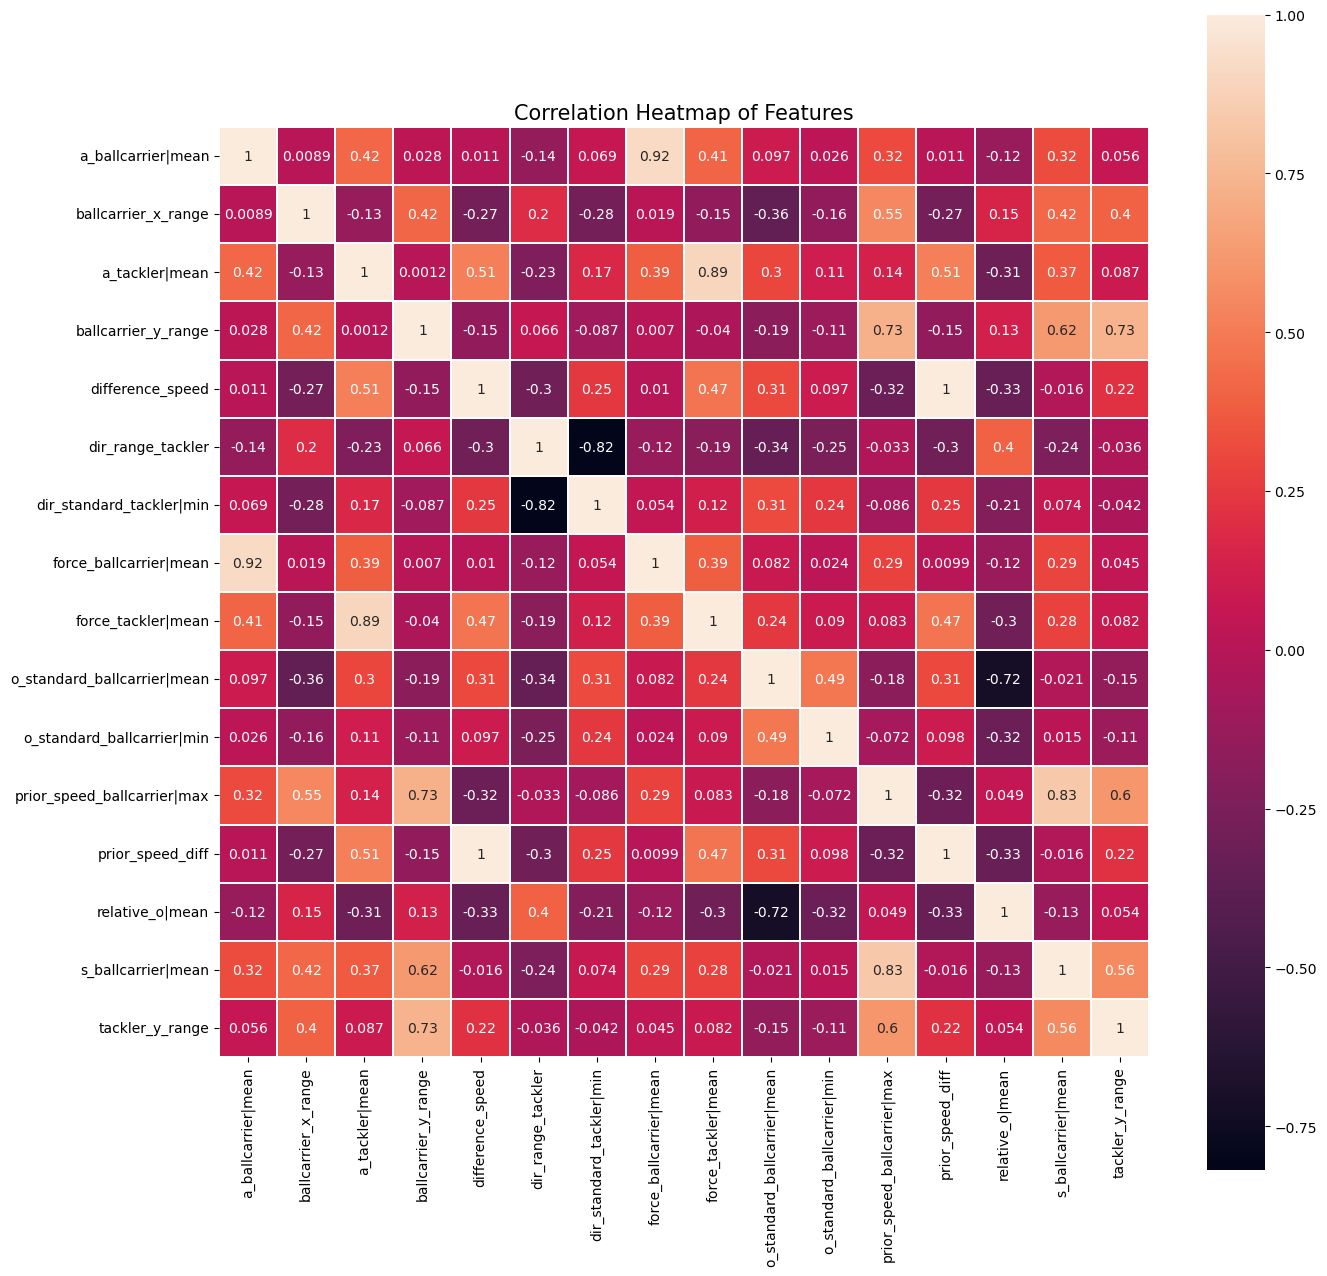

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,15))
plt.title('Correlation Heatmap of Features', size=15)

sns.heatmap(df_final_subset[final_cols].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=True)

In [32]:
df_set=df_final[['displayName','nflId_tackler','tackle_event|max','missed_tackle|max','assist|max',
'a_ballcarrier|mean',
 'ballcarrier_x_range',
 'a_tackler|mean',
 'ballcarrier_y_range',
 'difference_speed',
 'dir_range_tackler',
 'dir_standard_tackler|min',
 'force_ballcarrier|mean',
 'force_tackler|mean',
 'o_standard_ballcarrier|mean',
 'o_standard_ballcarrier|min',
 'prior_speed_ballcarrier|max',
 'prior_speed_diff',
 'relative_o|mean',
 's_ballcarrier|mean',
 'tackler_y_range'

]].groupby(by=['displayName']).mean().reset_index()
df_set

df_set_gameplays=df_final[['displayName', 'gameplayid', 'nflId_tackler']].groupby(by=['displayName', 'nflId_tackler']).nunique().reset_index()
df_set_tackleassist=df_final[['displayName', 'tackle_event|max', 'missed_tackle|max', 'assist|max']].groupby(by='displayName').sum().reset_index()
df_set['gameplayid|nunique']=df_set_gameplays['gameplayid']
df_set[['tackle_count', 'missedTacklecount', 'assist_count']]=df_set_tackleassist[['tackle_event|max', 'missed_tackle|max', 'assist|max']]


In [33]:
df_final=df_final[(df_final['tackle_event|max']+ df_final['missed_tackle|max']==1)& (df_final['assist|max']==0)]


In [34]:
# Compare Algorithms
#!pip install xgboost
import pandas
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold,StratifiedGroupKFold, train_test_split
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


X=df_final[final_cols
    
]

groups=df_final['displayName']
y=df_final['tackle_event|max']



In [35]:
lgbmparams= {'lambda_l1': 4.152388101674801, 'lambda_l2': 0.17474066980275066, 'num_leaves': 245, 'feature_fraction': 0.6192761230532181, 'bagging_fraction': 0.40583520811450247, 'bagging_freq': 4, 'min_child_samples': 44, 'learning_rate': 0.09037380952114289, 'class_weight':{0:2, 1:1}}
xgbparams=  {'max_depth': 6, 'learning_rate': 0.10321364517892449, 'n_estimators': 133, 'min_child_weight': 4, 'gamma': 3.7370606814124185e-07, 'subsample': 0.21039282194760126, 'colsample_bytree': 0.46503745302099037, 'reg_alpha': 0.00013987403882012288, 'reg_lambda': 8.588226259083729e-06}
rfparams= {'n_estimators': 197, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 3}

Accuracy: 0.8011161846778285
F1: 0.4447887323943662
Precision: 0.40055809233891426
Recall: 0.5
Kappa: 0.0
AUC:  0.5


Text(0.5, 1.0, 'Confusion Matrix')

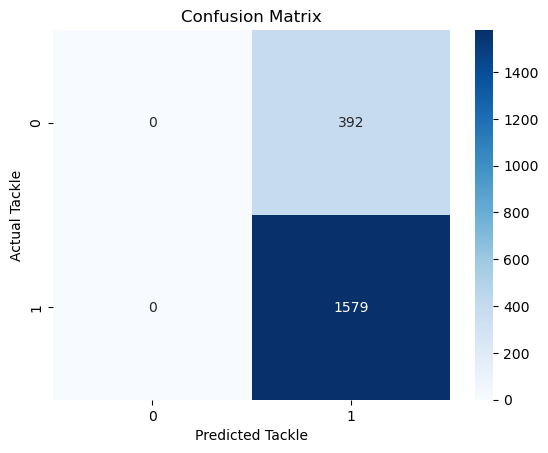

In [36]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_auc_score




dummy_clf = DummyClassifier(strategy="most_frequent")
X=df_final[final_cols
    
]
X.fillna(0, inplace=True) ##fill in missing pass length to 0
groups=df_final['displayName']
y=df_final['tackle_event|max']

X_train, X_test, y_train, y_test = train_test_split(X ,y, stratify=y, test_size=0.2, random_state=1)

dummy_clf.fit(X_train, y_train)



y_pred =  dummy_clf.predict(X_test)
y_proba=dummy_clf.predict_proba(X_test)
matrix = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy_score(y_test, y_pred))

print("F1:", f1_score(y_test, y_pred,average='macro'))
print("Precision:", precision_score(y_test, y_pred,average='macro'))
print("Recall:", recall_score(y_test, y_pred,average='macro'))
print("Kappa:", cohen_kappa_score(y_test, y_pred))

print("AUC: ", roc_auc_score(y_test, y_pred))


sns.heatmap(matrix, annot=True,  cmap="Blues", fmt="g")
plt.xlabel('Predicted Tackle'); plt.ylabel('Actual Tackle'); plt.title('Confusion Matrix')

In [37]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score
from typing import Tuple
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import TomekLinks

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule

model =LGBMClassifier(**lgbmparams)
X=df_final[final_cols
    
]
X.fillna(0, inplace=True) ##fill in missing pass length to 0
groups=df_final['displayName']
y=df_final['tackle_event|max']
kfold=StratifiedKFold(n_splits=5,  random_state=None, shuffle=True)
def cross_val_predict(model, kfold : KFold, X : np.array, y : np.array) -> Tuple[np.array, np.array]:

    kfold=StratifiedKFold(n_splits=5,  random_state=None, shuffle=True)
    groups=df_final['displayName']
    
    
    
    no_classes = len(np.unique(y))
    
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes]) 

    for train_ndx, test_ndx in kfold.split(X, y):

        X_train, y_train, X_test, y_test = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]
       
        
        model.fit(
            X_train, y_train
        )


        


      
        actual_classes = np.append(actual_classes, y_test)
        

        predicted_classes = np.append(predicted_classes, model.predict(X_test))

        try:
            predicted_proba = np.append(predicted_proba, model.predict_proba(X_test), axis=0)
        except:
            predicted_proba = np.append(predicted_proba, np.zeros((len(X_test), no_classes), dtype=float), axis=0)

    return actual_classes, predicted_classes, predicted_proba
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):

    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    print("Accuracy:", accuracy_score(actual_classes, predicted_classes))

    print("F1:", f1_score(actual_classes, predicted_classes,average='macro'))
    print("Precision:", precision_score(actual_classes, predicted_classes,average='macro'))
    print("Recall:", recall_score(actual_classes, predicted_classes,average='macro'))
    print("Kappa:" , cohen_kappa_score(actual_classes, predicted_classes))
    print("AUC: ",  roc_auc_score(actual_classes, predicted_classes))
    plt.figure()
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted Tackle'); plt.ylabel('Actual Tackle'); plt.title('Confusion Matrix')

    plt.show()
    


In [ ]:



df_train, df_test = train_test_split(df_final, stratify=df_final['tackle_event|max'], test_size=0.25, random_state=0)
import shap
# DF, based on which importance is checked
X_train=df_train[final_cols
    ]
df_test=df_test.reset_index()
X_test=df_test[final_cols]
y_train=df_train['tackle_event|max']
y_test=df_test['tackle_event|max']

model1=XGBClassifier(**xgbparams)
model1.fit(X_train, y_train)
probs1=model1.predict_proba(X_test)
model2=LGBMClassifier(**lgbmparams)
model2.fit(X_train, y_train)
probs2=model2.predict_proba(X_test)
model3=RandomForestClassifier(**rfparams)
model3.fit(X_train, y_train)
probs3=model3.predict_proba(X_test)






In [39]:
df_test['prob_tackle1']=probs1[:, 1]
df_test['prob_miss1']=probs1[:, 0]

df_test['prob_tackle2']=probs2[:, 1]
df_test['prob_miss2']=probs2[:, 0]



df_test['prob_tackle3']=probs3[:, 1]
df_test['prob_miss3']=probs3[:, 0]


df_test['prob_tackle']=(df_test['prob_tackle1']+df_test['prob_tackle2']+df_test['prob_tackle3'])/3
df_test['prob_miss']=(df_test['prob_miss1']+df_test['prob_miss2']+df_test['prob_miss3'])/3

df_test['prediction']=np.where(df_test['prob_tackle']>.5, 1, 0)

df_test['y_test']=y_test

Accuracy: 0.8563311688311688
F1: 0.7358720930232558
Precision: 0.7976997034774014
Recall: 0.7055145462440295
Kappa: 0.4768765743073048
AUC:  0.7055145462440295


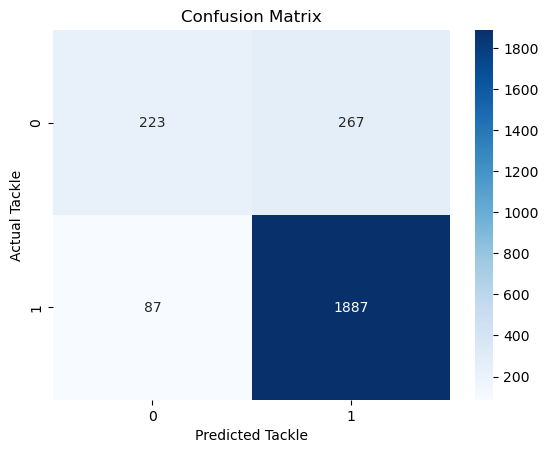

In [40]:
plot_confusion_matrix(df_test['y_test'], df_test['prediction'], [0,1])

In [41]:
X=df_set[final_cols]


probs1=model1.predict_proba(X)
probs2=model2.predict_proba(X)
probs3=model3.predict_proba(X)

df_set['prob_tackle1']=probs1[:, 1]
df_set['prob_miss1']=probs1[:, 0]


df_set['prob_tackle2']=probs2[:, 1]
df_set['prob_miss2']=probs2[:, 0]



df_set['prob_tackle3']=probs3[:, 1]
df_set['prob_miss3']=probs3[:, 0]


df_set['ETSR']=(df_set['prob_tackle1']+df_set['prob_tackle2']+df_set['prob_tackle3'])/3




[LightGBM] [Warning] feature_fraction is set=0.6192761230532181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6192761230532181
[LightGBM] [Warning] lambda_l1 is set=4.152388101674801, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.152388101674801
[LightGBM] [Warning] lambda_l2 is set=0.17474066980275066, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17474066980275066
[LightGBM] [Warning] bagging_fraction is set=0.40583520811450247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40583520811450247
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [42]:
df_set['tackle_index']=round((df_set['ETSR']*((df_set['tackle_count']*1)+(df_set['assist_count']*.5)))-((1-df_set['ETSR'])*(df_set['missedTacklecount']+1)), 2)

In [43]:

df_tackler_merge=pd.merge(df_players[['nflId', 'position', 'displayName']], df_set[['displayName', 'tackle_index', 'ETSR']], on='displayName')
df_tackles_grouped=df_tackles[['nflId', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']].groupby('nflId').sum() 
df_tackler_merge=pd.merge(df_tackler_merge, df_tackles_grouped, on='nflId')
df_tackler_merge.sort_values(by='tackle_index', ascending=False, inplace=True)
df_tackler_merge.reset_index(inplace=True)
df_tackler_merge[['displayName', 'position', 'tackle_index', 'ETSR', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']].sort_values(by='tackle_index', ascending=False).head(10)

,displayName,position,tackle_index,ETSR,tackle,assist,forcedFumble,pff_missedTackle
0,Foyesade Oluokun,ILB,58.87,0.897048,59,26,0,11
1,Zaire Franklin,OLB,57.06,0.921843,55,28,0,12
2,Roquan Smith,ILB,55.04,0.920245,50,32,0,7
3,C.J. Mosley,ILB,53.80,0.884518,55,32,0,8
4,Rashaan Evans,ILB,52.19,0.890112,45,39,1,6
5,Jordyn Brooks,ILB,51.54,0.890321,61,23,1,10
6,Bobby Okereke,ILB,50.23,0.928212,48,23,1,4
7,Nick Bolton,ILB,47.26,0.905510,46,23,0,2
8,David Long,CB,45.70,0.901609,10,3,0,4
9,David Long,ILB,45.70,0.901609,35,26,0,9


<center><span style="font-size:36px;">  C.J. Mosley vs. Tony Adams</span> </center>

C.J.  Mosley is a top player from the NY Jets, but we wanted to look at his tackling stats compared to his teammate, Tony Adams. Mosley had **158 combined tackles and assists in 2022 and 131 in 2023**. Based on an analysis of his plays from 2022, his **ETSR is .73**, yet his tackle index is very high, putting him in the **top 10 players**.

On the other hand, Tony Adams has an **extremely high ETSR of .88 based on his 1 successful assist** that was recorded in our 2022 tracking data. His tackle index in 2022 was very low because he didn't play in many games, but based on the actions he took during that play, we expect his tackle success rate to be high, which is supported by his performance in 2023.



<br></br>
 <center><img src="https://static.clubs.nfl.com/image/private/t_editorial_landscape_6_desktop/f_png/jets/h0j0fahb2xtffumugal3.png" alt="CJ Mosley" width="300"/></center>
 <center>C.J. Mosley</center> 

<br></br>

<center>

|SEASON |TEAM   |  TKL  |  AST  |  COMBINED |
| ----- | ----- |-------|-------|-----------|
|2023   |NY Jets|  72   |   59  |   131     |
|2022   |NY Jets|  99   |   59  |  158      |

</center>
 <br></br> 

In [44]:
df_tackler_merge[df_tackler_merge['displayName']=='C.J. Mosley'][['displayName', 'position', 'tackle_index', 'ETSR', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']]

,displayName,position,tackle_index,ETSR,tackle,assist,forcedFumble,pff_missedTackle
3,C.J. Mosley,ILB,53.8,0.884518,55,32,0,8


 > ## "We have all these guys that play at an All-Pro level, and it makes you want to be better," Adams said. "I am just going out there and trying to be better because of those guys. And one day, I have hopes to play at that level too." 
  [NewYorkJets.com](https://www.newyorkjets.com/news/jets-tony-adams-buffalo-bills-josh-allen)

#### Maybe he can...


<br></br><center> <img src="https://static.clubs.nfl.com/image/private/t_editorial_landscape_6_desktop/f_png/jets/jtsntdaohmgigyike1hq.png" alt="Tony Adams" width="300"/></center>
## <center>Tony Adams</center>  
<br></br>

<center>

|SEASON |TEAM   |  TKL  |  AST  |  COMBINED |
| ----- | ----- |-------|-------|-----------|
|2023   |NY Jets|  45   |   22  |   67      |
|2022   |NY Jets|  10   |   7   |  17       |

</center>


In [45]:
(df_tackler_merge[df_tackler_merge['displayName']=='Tony Adams'][['displayName', 'position', 'tackle_index', 'ETSR', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']])

,displayName,position,tackle_index,ETSR,tackle,assist,forcedFumble,pff_missedTackle
748,Tony Adams,FS,0.33,0.888271,0,1,0,0



# Testing the ETSR and Tackle Index <a class="anchor"  id="5"></a>

 <center><b><i> A good test for the ETSR model would be to use his stats from his 2023 tracking data (or the second part of 2022) to determine if his tackle index increased and what happened to his ETSR. </i></b></center> 


## Incorrect Classifications

We decided to analyze two plays that the ETSR model "misclassified". We have one play the model predicted would be a tackle but was a miss, and another that the model predicted would be a miss but was a successful tackle. The two plays are analyzed below:


In [46]:
index_White=df_test[(df_test['gameplayid']=='20221023012468')].index.to_list()
index_Newsome=df_test[(df_test['gameplayid']=='2022100902730')].index.to_list()





### Week 1  2022: Panthers vs. Buccaneers

The first play we're going to look at is one from Week 1 of the 2022 season. It was the Panthers vs. the Bucanneers. 
- [View Next Gen Animation](https://nextgenstats.nfl.com/highlights/play/type/team/2022/1/playerId/2022102301/2468)
<br></br>
Hubbard ran 17 yards for a touchdown and White missed the tackle. The model predicted this would be a successful tackle. The reason for this is that White's positioning was appropriate at the time of the tackle attempt and his acceleration was high enough to overcome Hubbard. However, we can see that he moved in the wrong direction when it came time to tackle. Most of the other conditions were suited for White to make the tackle, but he missed it. Therefore, the **ETSR is high but since White missed the tackle, this will count against him for his tackle index**.
<br></br>
The figure below shows an example of how the different features contributed to the model's outcome.

In [47]:
import lime
from lime import lime_tabular
display(df_test.iloc[index_White])

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Miss', 'Tackle'],
    mode='classification'
)
exp = explainer.explain_instance(
    data_row=X_test.iloc[index_White[0]], 
    predict_fn=model1.predict_proba
)

exp.show_in_notebook(show_table=True)
exp = explainer.explain_instance(
    data_row=X_test.iloc[index_White[0]],  
    predict_fn=model2.predict_proba
)

#exp.show_in_notebook(show_table=True)

exp = explainer.explain_instance(
    data_row=X_test.iloc[index_White[0]], 
    predict_fn=model3.predict_proba
)

#exp.show_in_notebook(show_table=True)


,index,gameplayid,displayName,nflId_tackler,nflId_ballcarrier,tackle_event|max,assist|max,missed_tackle|max,playNullifiedByPenalty|max,relative_o|mean,...,prob_tackle1,prob_miss1,prob_tackle2,prob_miss2,prob_tackle3,prob_miss3,prob_tackle,prob_miss,prediction,y_test
92,11978,20221023012468,Devin White,47788,53555,0,0,1,0,182.377963,...,0.935527,0.064473,0.850079,0.149921,0.7615,0.2385,0.849035,0.150965,1,0


[LightGBM] [Warning] feature_fraction is set=0.6192761230532181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6192761230532181
[LightGBM] [Warning] lambda_l1 is set=4.152388101674801, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.152388101674801
[LightGBM] [Warning] lambda_l2 is set=0.17474066980275066, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17474066980275066
[LightGBM] [Warning] bagging_fraction is set=0.40583520811450247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40583520811450247
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


### Week 5: Browns vs. Chargers


The next play is an example of a a successful tackle that the model predicted would be a miss. 

- [View Next Gen Animation](https://nextgenstats.nfl.com/highlights/play/type/team/2022/1/playerId/2022100902/730)

<br></br>
In this play A.Ekeler had an amazing 71 yard run. In the end, Newsome tackled him before he made the touchdown, but not before he gained 71 yards for the Chargers. The model predicted this would bwe a failed tackle because Ekeler had already covered so much distance. In addition, Ekeler was going at top speed. In the end, Newsome caught up to him and was able to speed up enough to make the tackle, but the model treats this as a "poor" tackle due to the fact that so many yards were gained. The ETSR will go down for this play, but the tackle index will go up for making the tackle.

In [48]:
display(df_test.iloc[index_Newsome])
explainer2 = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Miss', 'Tackle'],
    mode='classification'
)
exp = explainer2.explain_instance(
    data_row=X_test.iloc[index_Newsome[0]], 
    predict_fn=model1.predict_proba
)

exp.show_in_notebook(show_table=True)


,index,gameplayid,displayName,nflId_tackler,nflId_ballcarrier,tackle_event|max,assist|max,missed_tackle|max,playNullifiedByPenalty|max,relative_o|mean,...,prob_tackle1,prob_miss1,prob_tackle2,prob_miss2,prob_tackle3,prob_miss3,prob_tackle,prob_miss,prediction,y_test
2,8384,2022100902730,Greg Newsome,53455,45573,1,0,0,0,18.665089,...,0.318867,0.681133,0.198633,0.801367,0.392216,0.607784,0.303239,0.696761,0,1


# How is this useful and innovative? <a class="anchor"  id="6"></a>
We anticipate several use cases for our predictive model:
1. **Drafting new players** - based on tracking stats from prior tackle attempts, coaches and determine if a new player's ETSR makes them a good candidate for their team
2. **Adding to the PFF Player Grades** - We recommend adding a Tackle Grade in the PFF Player Grade cards. 
3. **Monitoring Player Progress** - If a player's ETSR starts to drop, it can mean that they are playing more inconsistently in terms of their tackling outcomes

[Full Code Available Here](https://github.com/meagvo/nfl-big-data-bowl-2024/blob/nfl/etsr-tackle-index.ipynb)
